# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [3]:
imgpath = "C:/Datasets/Sports/sportimages/sportimages"

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
C:\Users\chuy-\AppData\Local\Temp\ipykernel_18836\3883684103.py:13: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):


leyendo imagenes de  C:/Datasets/Sports/sportimages/sportimages
C:/Datasets/Sports/sportimages/sportimages\americano 1
C:/Datasets/Sports/sportimages/sportimages\basket 9348
C:/Datasets/Sports/sportimages/sportimages\beisball 8823
C:/Datasets/Sports/sportimages/sportimages\boxeo 7752
C:/Datasets/Sports/sportimages/sportimages\ciclismo 7125
C:/Datasets/Sports/sportimages/sportimages\f1 7533
C:/Datasets/Sports/sportimages/sportimages\futbol 5053
C:/Datasets/Sports/sportimages/sportimages\golf 7617
C:/Datasets/Sports/sportimages/sportimages\natacion 9768
C:/Datasets/Sports/sportimages/sportimages\tenis 5172
Directorios leidos: 10
Imagenes en cada directorio [9349, 8823, 7752, 7125, 7533, 5053, 7617, 9768, 5172, 8936]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [49]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [50]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [51]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [73]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 1')

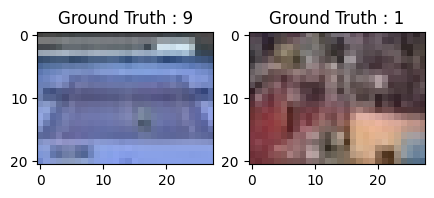

In [74]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [75]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [76]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [77]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [78]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [124]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 40 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 128 # cantidad de imágenes que se toman a la vez en memoria

In [125]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',padding='same'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Conv2D(128, kernel_size=(3, 3),activation='linear',padding='same'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

C:\Users\chuy-\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\chuy-\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [126]:
sport_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 21, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 21, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 11, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 11, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 11, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 6, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 6, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │       172,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,642 (1.01 MB)

 Trainable params: 265,642 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [127]:
sport_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR),
    metrics=['accuracy']
)


# Entrenamos el modelo: Aprende a clasificar imágenes

In [128]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1209 - loss: 2.2965 - val_accuracy: 0.1248 - val_loss: 2.2759
Epoch 2/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1441 - loss: 2.2683 - val_accuracy: 0.1997 - val_loss: 2.2523
Epoch 3/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1720 - loss: 2.2360 - val_accuracy: 0.3120 - val_loss: 2.1986
Epoch 4/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2113 - loss: 2.1744 - val_accuracy: 0.4298 - val_loss: 2.1018
Epoch 5/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.2587 - loss: 2.0712 - val_accuracy: 0.5211 - val_loss: 1.9518
Epoch 6/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.3090 - loss: 1.9439 - val_accuracy: 0.5523 - val_loss: 1.7887
Epoch 7/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.3608 - loss: 1.8134 - val_accuracy: 0.5681 - val_loss: 1.6280
Epoch 8/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4031 - loss: 1.7035 - 

In [129]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist3_40e.keras")


# Evaluamos la red

In [130]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8030 - loss: 0.6942


In [131]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6942155957221985
Test accuracy: 0.802994966506958


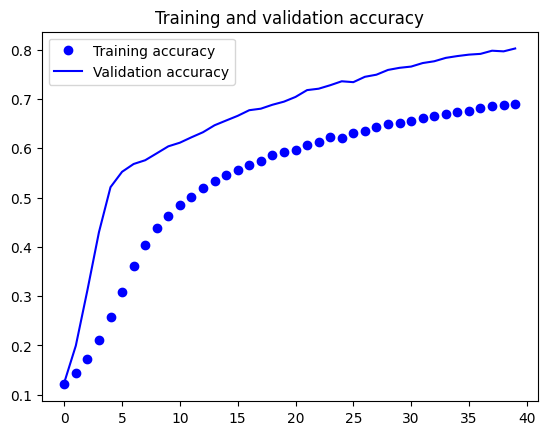

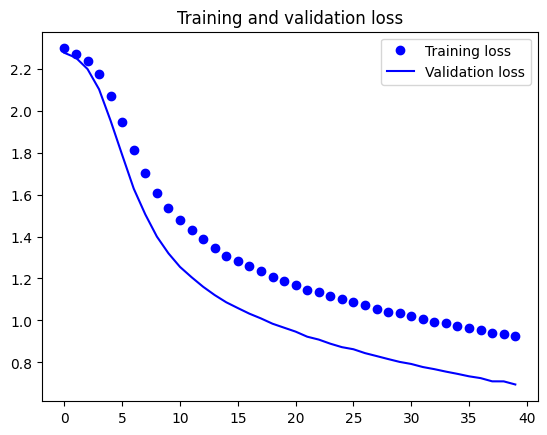

In [132]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [133]:
predicted_classes2 = sport_model.predict(test_X)

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [134]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [135]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 12387 correct labels


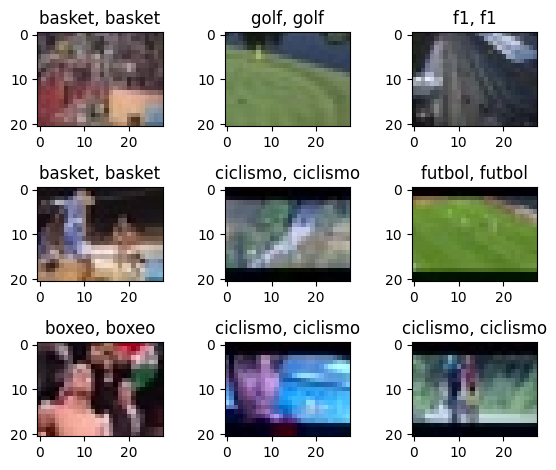

In [136]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 3039 incorrect labels


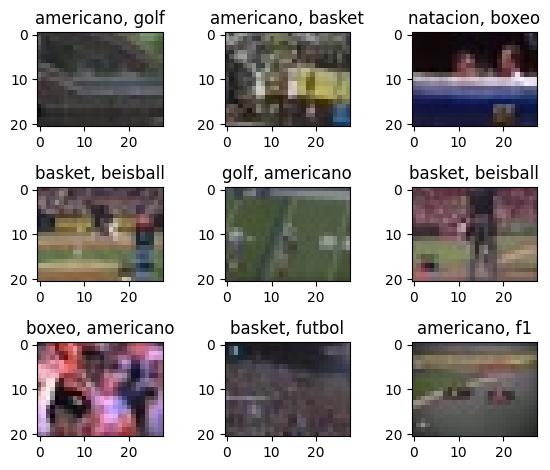

In [137]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [138]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.59      0.64      0.61      1872
     Class 1       0.70      0.86      0.77      1826
     Class 2       0.71      0.70      0.71      1515
     Class 3       0.86      0.93      0.89      1433
     Class 4       0.98      0.99      0.99      1482
     Class 5       0.90      0.18      0.31       997
     Class 6       0.94      0.83      0.88      1578
     Class 7       0.74      0.79      0.76      1936
     Class 8       0.95      0.94      0.94      1044
     Class 9       0.93      1.00      0.96      1743

    accuracy                           0.80     15426
   macro avg       0.83      0.79      0.78     15426
weighted avg       0.81      0.80      0.79     15426



# Prediccion de una nueva imagen

In [53]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['basket.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

FileNotFoundError: [Errno 2] No such file or directory: 'basket.jpg'